# Day 5: Factor Exposure Analysis

## Learning Objectives
- Analyze portfolio factor exposures
- Understand factor risk contribution
- Decompose portfolio returns by factor
- Build factor-tilted portfolios

## Key Concept
$$\text{Portfolio Return} = \alpha + \sum_{k=1}^{K} \beta_k^P \cdot F_k + \epsilon$$

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from pathlib import Path

# Configuration
DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Load data
df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna()

print("="*60)
print("FACTOR EXPOSURE ANALYSIS - DAY 5")
print("="*60)
print(f"Data: {len(returns)} days, {len(returns.columns)} assets")

FACTOR EXPOSURE ANALYSIS - DAY 5
Data: 1834 days, 63 assets


## 1. Construct Factors

In [2]:
# Market factor
daily_rf = RISK_FREE_RATE / TRADING_DAYS
MKT = returns['SPY'] - daily_rf

# SMB - Size factor
volatilities = returns.std()
median_vol = volatilities.median()
small = [s for s in volatilities[volatilities > median_vol].index if s != 'SPY']
big = [s for s in volatilities[volatilities <= median_vol].index if s != 'SPY']
SMB = returns[small].mean(axis=1) - returns[big].mean(axis=1)

# HML - Value factor
past_ret = returns.rolling(126).mean().iloc[-1]
median_ret = past_ret.median()
value = [s for s in past_ret[past_ret < median_ret].index if s != 'SPY']
growth = [s for s in past_ret[past_ret >= median_ret].index if s != 'SPY']
HML = returns[value].mean(axis=1) - returns[growth].mean(axis=1)

# MOM - Momentum factor
mom_12m = returns.rolling(252).mean().iloc[-1]
mom_1m = returns.rolling(21).mean().iloc[-1]
mom_signal = mom_12m - mom_1m  # 12-1 momentum
median_mom = mom_signal.median()
winners = [s for s in mom_signal[mom_signal >= median_mom].index if s != 'SPY']
losers = [s for s in mom_signal[mom_signal < median_mom].index if s != 'SPY']
MOM = returns[winners].mean(axis=1) - returns[losers].mean(axis=1)

# Combine factors
factors = pd.DataFrame({
    'MKT': MKT,
    'SMB': SMB,
    'HML': HML,
    'MOM': MOM
}).dropna()

print("\n📊 Factor Statistics (Annualized):")
print(f"{'Factor':<8} {'Return':<12} {'Volatility':<12} {'Sharpe':<10}")
print("-"*45)
for col in factors.columns:
    ret = factors[col].mean() * TRADING_DAYS
    vol = factors[col].std() * np.sqrt(TRADING_DAYS)
    sharpe = ret / vol if vol > 0 else 0
    print(f"{col:<8} {ret:<12.2%} {vol:<12.2%} {sharpe:<10.3f}")


📊 Factor Statistics (Annualized):
Factor   Return       Volatility   Sharpe    
---------------------------------------------
MKT      12.32%       19.38%       0.636     
SMB      12.68%       20.37%       0.622     
HML      -7.65%       17.92%       -0.427    
MOM      -5.69%       18.49%       -0.308    


## 2. Calculate Stock Factor Exposures

In [3]:
def get_factor_exposures(stock_returns, factors):
    """Calculate factor exposures via regression."""
    excess_returns = stock_returns - daily_rf
    aligned = pd.concat([excess_returns, factors], axis=1).dropna()
    y = aligned.iloc[:, 0]
    X = sm.add_constant(aligned[factors.columns])
    model = sm.OLS(y, X).fit()
    return model

# Calculate exposures for all stocks
exposures = {}
for stock in returns.columns:
    if stock != 'SPY':
        try:
            model = get_factor_exposures(returns[stock], factors)
            exposures[stock] = {
                'alpha': model.params['const'] * TRADING_DAYS,
                'MKT': model.params['MKT'],
                'SMB': model.params['SMB'],
                'HML': model.params['HML'],
                'MOM': model.params['MOM'],
                'R2': model.rsquared
            }
        except:
            pass

exposure_df = pd.DataFrame(exposures).T

print("\n" + "="*70)
print("FACTOR EXPOSURES (TOP 10 by R²)")
print("="*70)
top10 = exposure_df.nlargest(10, 'R2')
print(top10.round(3))


FACTOR EXPOSURES (TOP 10 by R²)
      alpha    MKT    SMB    HML     MOM     R2
IRX   0.333  1.990  9.353  7.467  11.613  0.918
DIA  -0.018  0.889 -0.016  0.151  -0.189  0.900
QQQ   0.020  1.183  0.040 -0.328   0.361  0.898
XLK   0.038  1.268  0.050 -0.245   0.244  0.878
IWM  -0.077  0.921  0.220 -0.192  -0.130  0.784
XLF  -0.021  0.858  0.140  0.274  -0.481  0.764
XLV   0.011  0.883 -0.295  0.245  -0.007  0.678
MSFT  0.086  1.342 -0.232  0.063   0.193  0.669
BLK   0.046  1.227 -0.187  0.411  -0.435  0.666
MS    0.047  0.903  0.468 -0.024  -0.467  0.651


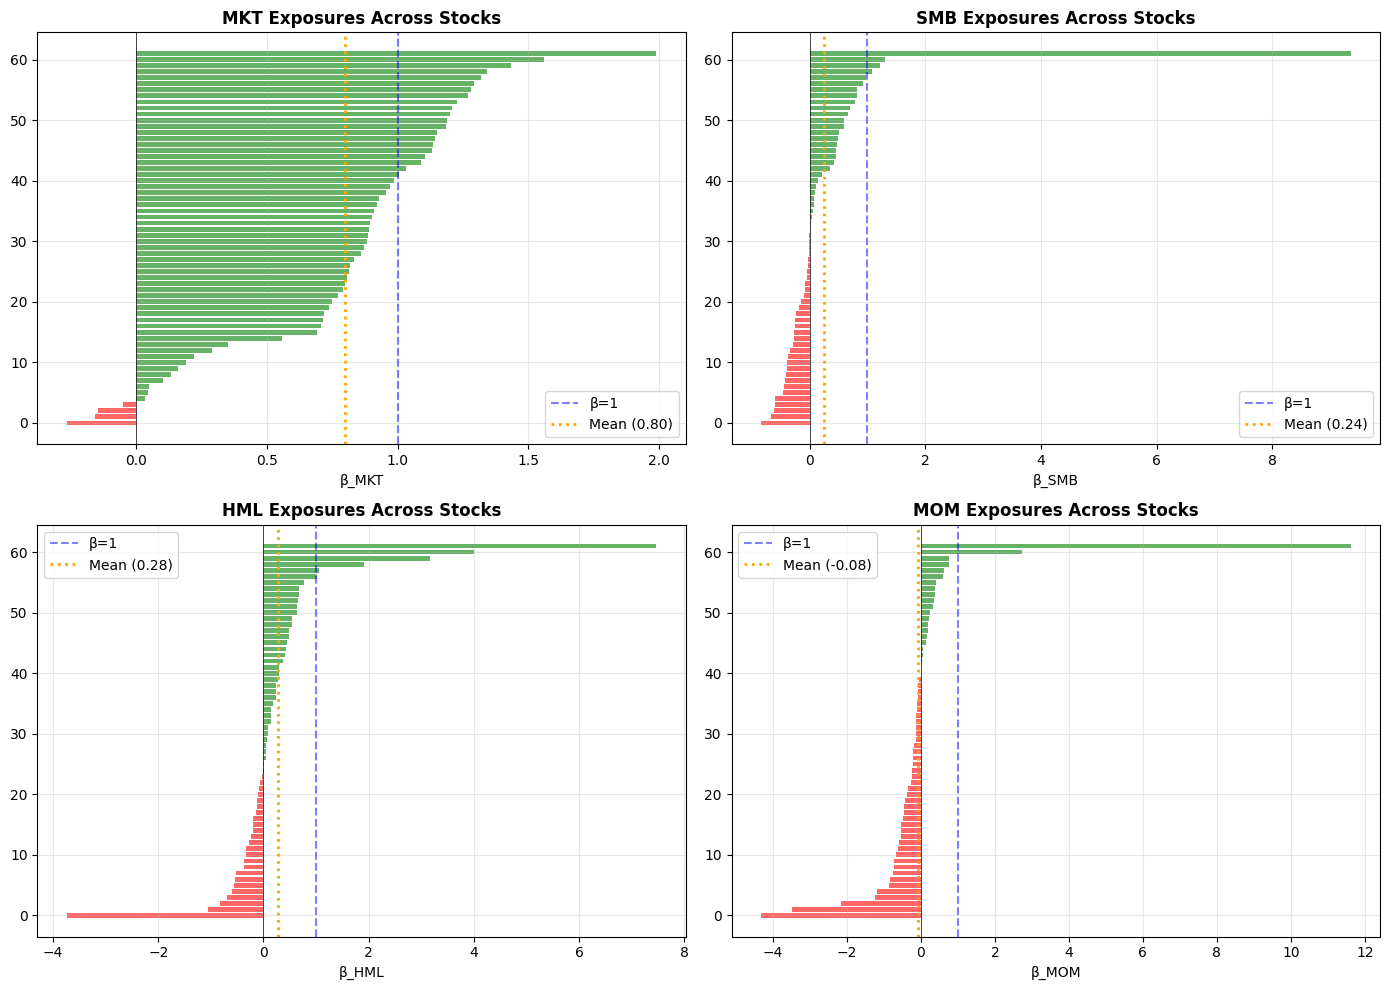

In [4]:
# Visualize factor exposures
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

factor_cols = ['MKT', 'SMB', 'HML', 'MOM']

for i, (ax, factor) in enumerate(zip(axes.flatten(), factor_cols)):
    exposures_sorted = exposure_df[factor].sort_values()
    
    colors = ['red' if x < 0 else 'green' for x in exposures_sorted]
    ax.barh(range(len(exposures_sorted)), exposures_sorted.values, color=colors, alpha=0.6)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.axvline(1, color='blue', linestyle='--', alpha=0.5, label='β=1')
    ax.set_title(f'{factor} Exposures Across Stocks', fontweight='bold')
    ax.set_xlabel(f'β_{factor}')
    ax.grid(True, alpha=0.3)
    
    # Add mean line
    mean_exp = exposure_df[factor].mean()
    ax.axvline(mean_exp, color='orange', linestyle=':', linewidth=2, label=f'Mean ({mean_exp:.2f})')
    ax.legend()

plt.tight_layout()
plt.show()

## 3. Portfolio Factor Exposure

In [5]:
# Create sample portfolio
portfolio_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'JPM', 'JNJ', 'XOM', 'PG']
portfolio_stocks = [s for s in portfolio_stocks if s in returns.columns]

# Equal weight portfolio
n_stocks = len(portfolio_stocks)
weights = np.ones(n_stocks) / n_stocks

# Calculate portfolio returns
portfolio_returns = (returns[portfolio_stocks] * weights).sum(axis=1)

# Portfolio factor exposure
portfolio_model = get_factor_exposures(portfolio_returns, factors)

print("\n" + "="*60)
print("PORTFOLIO FACTOR EXPOSURES (Equal Weight)")
print("="*60)
print(f"Stocks: {portfolio_stocks}")
print(f"\n{'Factor':<12} {'Exposure':<12} {'t-stat':<12} {'Significant'}")
print("-"*50)

for param in portfolio_model.params.index:
    if param == 'const':
        name = 'Alpha (Ann.)'
        value = portfolio_model.params[param] * TRADING_DAYS
    else:
        name = param
        value = portfolio_model.params[param]
    
    t_stat = portfolio_model.tvalues[param]
    sig = "✓" if portfolio_model.pvalues[param] < 0.05 else "✗"
    
    print(f"{name:<12} {value:<12.4f} {t_stat:<12.2f} {sig}")

print(f"\nR²: {portfolio_model.rsquared:.4f}")


PORTFOLIO FACTOR EXPOSURES (Equal Weight)
Stocks: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'JPM', 'JNJ', 'XOM', 'PG']

Factor       Exposure     t-stat       Significant
--------------------------------------------------
Alpha (Ann.) 0.0806       3.17         ✓
MKT          1.0519       96.70        ✓
SMB          0.0452       4.06         ✓
HML          -0.0996      -5.09        ✓
MOM          0.0924       5.34         ✓

R²: 0.9011


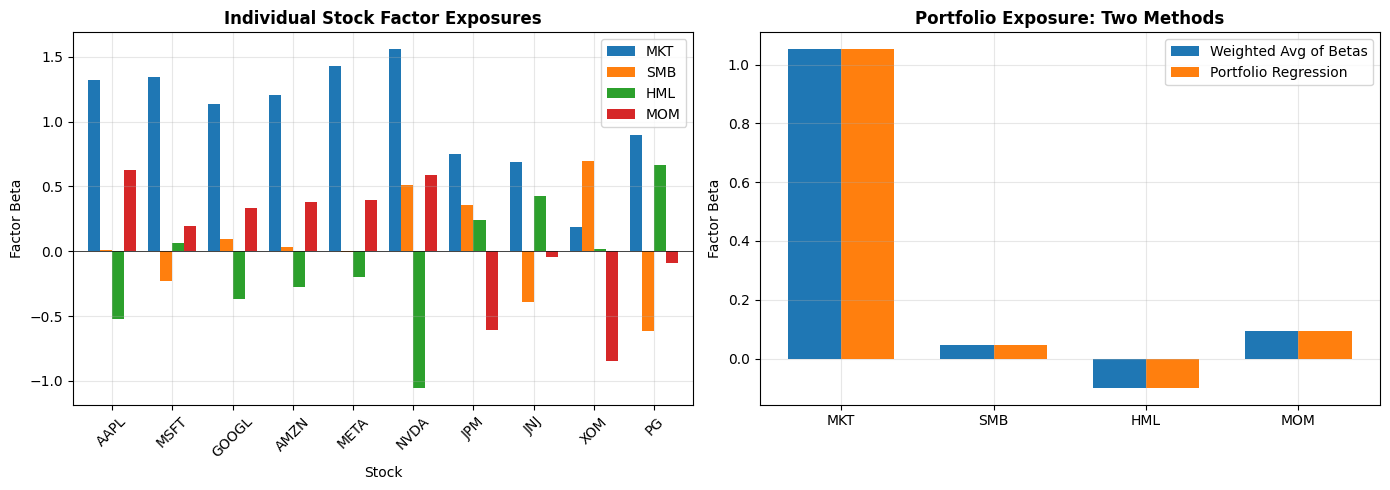


💡 Portfolio beta ≈ Weighted average of individual betas


In [6]:
# Compare individual vs portfolio exposures
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual exposures
ax1 = axes[0]
individual_exposures = exposure_df.loc[portfolio_stocks, ['MKT', 'SMB', 'HML', 'MOM']]
individual_exposures.plot(kind='bar', ax=ax1, width=0.8)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_title('Individual Stock Factor Exposures', fontweight='bold')
ax1.set_xlabel('Stock')
ax1.set_ylabel('Factor Beta')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Portfolio vs weighted average
ax2 = axes[1]
weighted_avg = (individual_exposures.T * weights).T.sum()
portfolio_exp = pd.Series({
    'MKT': portfolio_model.params['MKT'],
    'SMB': portfolio_model.params['SMB'],
    'HML': portfolio_model.params['HML'],
    'MOM': portfolio_model.params['MOM']
})

x = np.arange(4)
width = 0.35
ax2.bar(x - width/2, weighted_avg, width, label='Weighted Avg of Betas')
ax2.bar(x + width/2, portfolio_exp, width, label='Portfolio Regression')
ax2.set_xticks(x)
ax2.set_xticklabels(['MKT', 'SMB', 'HML', 'MOM'])
ax2.set_title('Portfolio Exposure: Two Methods', fontweight='bold')
ax2.set_ylabel('Factor Beta')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Portfolio beta ≈ Weighted average of individual betas")

## 4. Factor Risk Contribution

In [7]:
# Calculate factor risk contributions
factor_cov = factors.cov() * TRADING_DAYS
betas = portfolio_model.params[['MKT', 'SMB', 'HML', 'MOM']].values

# Factor variance contribution
factor_var = np.dot(np.dot(betas, factor_cov), betas)

# Total portfolio variance
portfolio_var = portfolio_returns.var() * TRADING_DAYS

# Idiosyncratic variance
idio_var = portfolio_var - factor_var

print("\n" + "="*60)
print("FACTOR RISK DECOMPOSITION")
print("="*60)
print(f"\nTotal Portfolio Variance (Ann.): {portfolio_var:.4f}")
print(f"Factor Variance:                  {factor_var:.4f} ({factor_var/portfolio_var*100:.1f}%)")
print(f"Idiosyncratic Variance:           {idio_var:.4f} ({idio_var/portfolio_var*100:.1f}%)")

# Individual factor contributions
print(f"\n{'Factor':<12} {'Variance Contrib':<18} {'% of Total':<12}")
print("-"*45)

for i, factor in enumerate(['MKT', 'SMB', 'HML', 'MOM']):
    factor_contrib = betas[i]**2 * factor_cov.iloc[i, i]
    print(f"{factor:<12} {factor_contrib:<18.6f} {factor_contrib/portfolio_var*100:<12.1f}%")


FACTOR RISK DECOMPOSITION

Total Portfolio Variance (Ann.): 0.0471
Factor Variance:                  0.0425 (90.1%)
Idiosyncratic Variance:           0.0047 (9.9%)

Factor       Variance Contrib   % of Total  
---------------------------------------------
MKT          0.041552           88.2        %
SMB          0.000085           0.2         %
HML          0.000318           0.7         %
MOM          0.000292           0.6         %


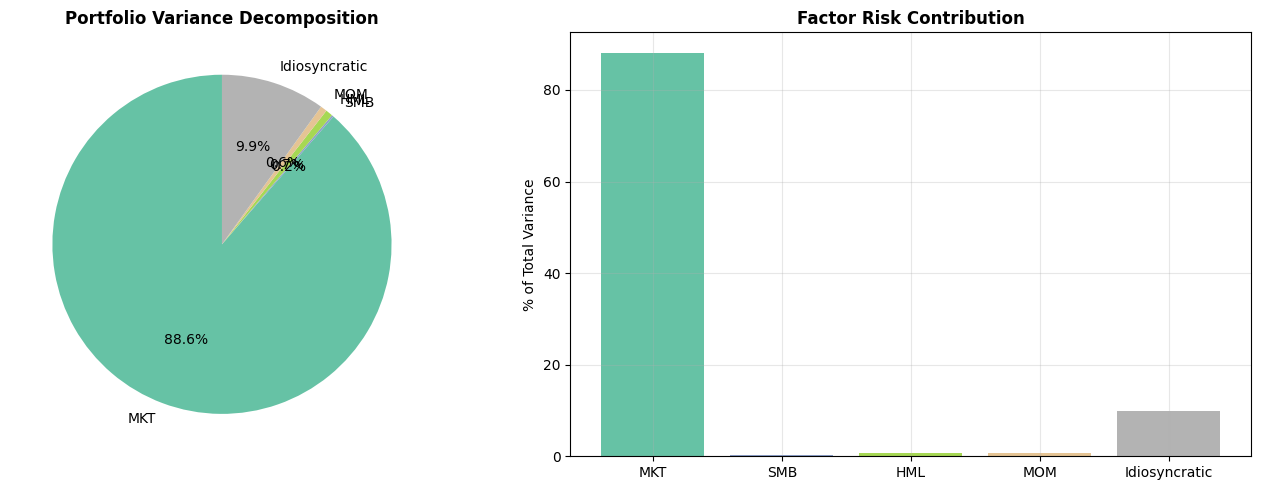

In [8]:
# Visualize risk decomposition
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of variance sources
ax1 = axes[0]
risk_sources = ['MKT', 'SMB', 'HML', 'MOM', 'Idiosyncratic']
var_contribs = [betas[i]**2 * factor_cov.iloc[i, i] for i in range(4)] + [idio_var]
var_pcts = [v/portfolio_var*100 for v in var_contribs]

colors = plt.cm.Set2(np.linspace(0, 1, 5))
ax1.pie(var_pcts, labels=risk_sources, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Portfolio Variance Decomposition', fontweight='bold')

# Bar chart
ax2 = axes[1]
ax2.bar(risk_sources, var_pcts, color=colors)
ax2.set_ylabel('% of Total Variance')
ax2.set_title('Factor Risk Contribution', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Factor-Tilted Portfolio Construction

In [9]:
# Build portfolios with different factor tilts
def build_tilted_portfolio(target_factor, tilt='high', n_stocks=10):
    """Build portfolio tilted toward a specific factor."""
    # Get stocks sorted by factor exposure
    sorted_stocks = exposure_df[target_factor].sort_values(ascending=(tilt=='low'))
    selected = sorted_stocks.head(n_stocks).index.tolist()
    
    # Equal weight
    weights = np.ones(len(selected)) / len(selected)
    
    # Calculate portfolio returns
    port_ret = (returns[selected] * weights).sum(axis=1)
    
    return selected, weights, port_ret

# Create different tilted portfolios
portfolios = {}

tilts = [
    ('High Beta', 'MKT', 'high'),
    ('Low Beta', 'MKT', 'low'),
    ('Small Cap', 'SMB', 'high'),
    ('Large Cap', 'SMB', 'low'),
    ('Value', 'HML', 'high'),
    ('Growth', 'HML', 'low'),
    ('Momentum', 'MOM', 'high'),
]

print("\n" + "="*70)
print("FACTOR-TILTED PORTFOLIOS")
print("="*70)

results = []
for name, factor, tilt in tilts:
    stocks, weights, port_ret = build_tilted_portfolio(factor, tilt)
    
    ann_ret = port_ret.mean() * TRADING_DAYS
    ann_vol = port_ret.std() * np.sqrt(TRADING_DAYS)
    sharpe = ann_ret / ann_vol
    
    # Get factor exposure
    model = get_factor_exposures(port_ret, factors)
    factor_exp = model.params[factor]
    
    results.append({
        'Portfolio': name,
        'Target Factor': factor,
        'Factor Exposure': factor_exp,
        'Return': ann_ret,
        'Volatility': ann_vol,
        'Sharpe': sharpe
    })
    portfolios[name] = port_ret

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


FACTOR-TILTED PORTFOLIOS
Portfolio Target Factor  Factor Exposure   Return  Volatility   Sharpe
High Beta           MKT         1.391467 0.313090    0.499346 0.627000
 Low Beta           MKT        -0.010371 0.101397    0.156728 0.646960
Small Cap           SMB         1.797063 0.279092    0.535132 0.521538
Large Cap           SMB        -0.544964 0.113164    0.175562 0.644579
    Value           HML         2.138718 0.182357    0.513329 0.355243
   Growth           HML        -0.928054 0.325200    0.250060 1.300488
 Momentum           MOM         1.860696 0.335143    0.487793 0.687061


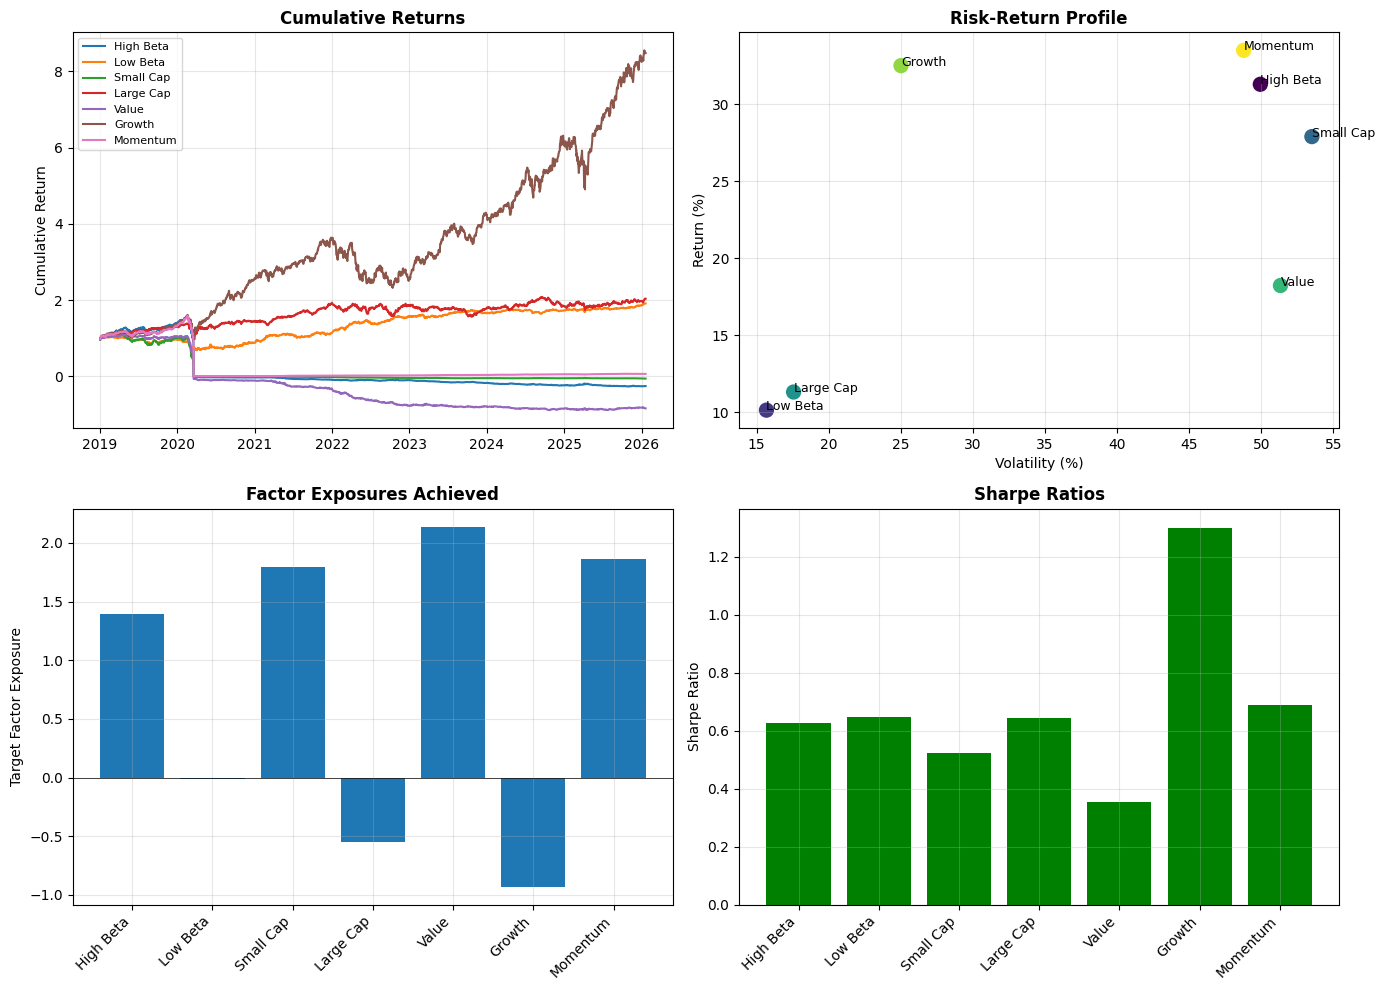

In [10]:
# Visualize tilted portfolio performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0, 0]
for name, ret in portfolios.items():
    cum_ret = (1 + ret).cumprod()
    ax1.plot(cum_ret, label=name)
ax1.set_title('Cumulative Returns', fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Risk-Return scatter
ax2 = axes[0, 1]
ax2.scatter(results_df['Volatility']*100, results_df['Return']*100, s=100, c=range(len(results_df)), cmap='viridis')
for i, row in results_df.iterrows():
    ax2.annotate(row['Portfolio'], (row['Volatility']*100, row['Return']*100), fontsize=9)
ax2.set_xlabel('Volatility (%)')
ax2.set_ylabel('Return (%)')
ax2.set_title('Risk-Return Profile', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Factor exposures bar
ax3 = axes[1, 0]
x = np.arange(len(results_df))
ax3.bar(x, results_df['Factor Exposure'])
ax3.set_xticks(x)
ax3.set_xticklabels(results_df['Portfolio'], rotation=45, ha='right')
ax3.set_ylabel('Target Factor Exposure')
ax3.set_title('Factor Exposures Achieved', fontweight='bold')
ax3.axhline(0, color='black', linewidth=0.5)
ax3.grid(True, alpha=0.3)

# Sharpe ratios
ax4 = axes[1, 1]
colors = ['green' if s > 0 else 'red' for s in results_df['Sharpe']]
ax4.bar(x, results_df['Sharpe'], color=colors)
ax4.set_xticks(x)
ax4.set_xticklabels(results_df['Portfolio'], rotation=45, ha='right')
ax4.set_ylabel('Sharpe Ratio')
ax4.set_title('Sharpe Ratios', fontweight='bold')
ax4.axhline(0, color='black', linewidth=0.5)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Takeaways

1. **Factor exposures** are calculated via regression on factor returns
2. **Portfolio beta ≈ Weighted average** of individual stock betas
3. **Risk decomposition** shows which factors drive portfolio volatility
4. **Factor tilting** allows targeting specific return drivers
5. **Trade-off** between factor concentration and diversification

---
*Next: Day 6 - Factor Portfolio Construction*